# Import Required Libraries
Import necessary libraries including OpenCV, NumPy, Matplotlib, and others needed for image processing and visualization.

In [1]:
# Import necessary libraries
import cv2  # OpenCV for image processing
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for visualization

# Ensure Matplotlib displays images inline in Jupyter Notebook
%matplotlib inline

# Load and Preprocess License Plate Image
Load the license plate image, resize if necessary, and convert to grayscale for processing.

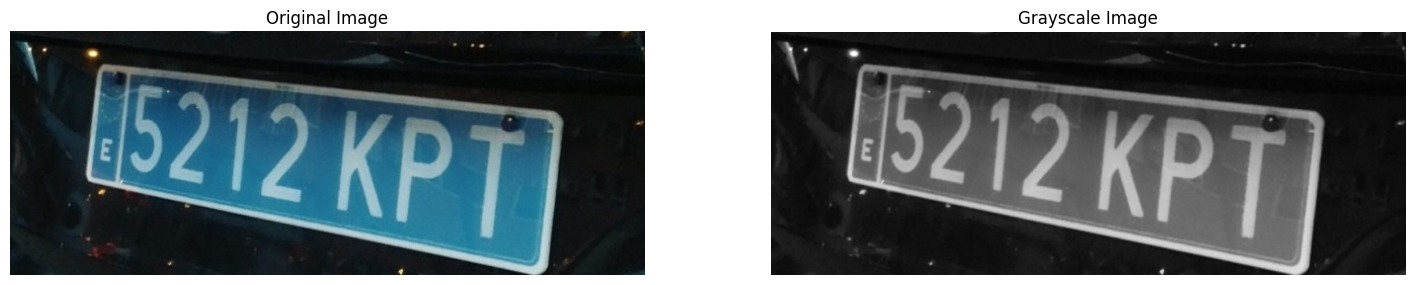

In [518]:
# Load and preprocess the license plate image

# Load the image using OpenCV (replace 'license_plate.jpg' with the path to your image)
image_path = '../deteccio_matricula/recortes/recorte_1.jpg'
#image_path = '../ocr/matricula1.jpg'
license_plate_image = cv2.imread(image_path)

# Check if the image was loaded successfully
if license_plate_image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Resize the image while maintaining the aspect ratio
height, width = license_plate_image.shape[:2]
new_width = 800  # Desired width
aspect_ratio = width / height
new_height = int(new_width / aspect_ratio)
resized_image = cv2.resize(license_plate_image, (new_width, new_height))

# Convert the image to grayscale
grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

# Display the original and preprocessed images
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(license_plate_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(grayscale_image, cmap="gray")
plt.axis("off")

plt.show()

Percentage of blue pixels: 9.30%


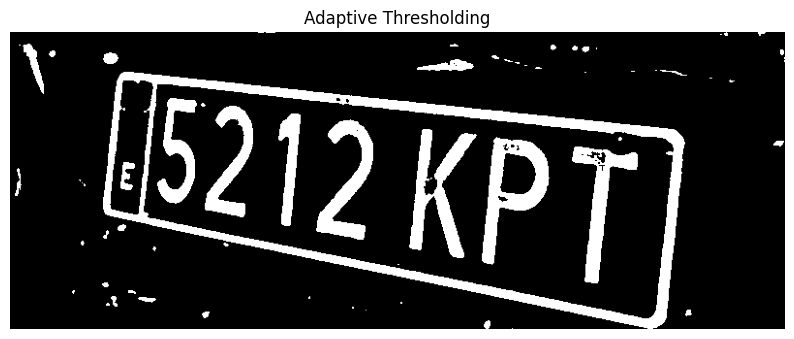

In [519]:
# Convert the license plate image to HSV color space
hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

# Define the range for blue color in HSV
lower_blue = np.array([100, 150, 50])
upper_blue = np.array([140, 255, 255])

# Create a mask for blue regions
blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

# Calculate the percentage of blue pixels in the image
blue_percentage = (np.sum(blue_mask > 0) / blue_mask.size) * 100

# Set a threshold to determine if the license plate is blue
is_blue_plate = blue_percentage > 5  # Adjust the threshold as needed

# Display the result
print(f"Percentage of blue pixels: {blue_percentage:.2f}%")

# Invertir la escala de grises
if is_blue_plate:  # Variable que indica si la matrícula es azul
    grayscale_image_blue = cv2.bitwise_not(grayscale_image)
    resized_image = cv2.cvtColor(grayscale_image_blue, cv2.COLOR_GRAY2BGR)

    # Apply adaptive thresholding to the inverted grayscale image
    thresh = cv2.bitwise_not(cv2.adaptiveThreshold(grayscale_image_blue, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 55, 16))

    # Display the adaptive thresholded image
    plt.figure(figsize=(10, 5))
    plt.title("Adaptive Thresholding")
    plt.imshow(thresh, cmap="gray")
    plt.axis("off")
    plt.show()

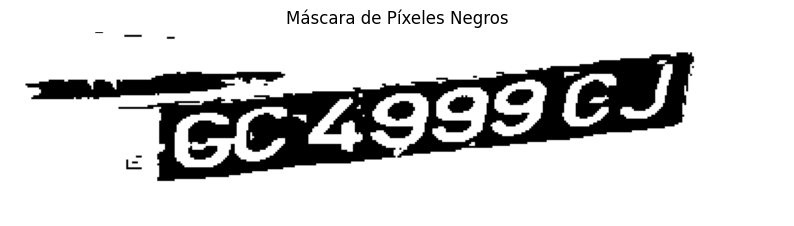

In [442]:
# Definir el rango para detectar píxeles negros
lower_black = np.array([0, 0, 0])  # Valor mínimo para negro
upper_black = np.array([255, 255, 155])  # Ajustar según sea necesario

# Crear una máscara para los píxeles negros
black_mask = cv2.inRange(resized_image, lower_black, upper_black)

# Mostrar la máscara de píxeles negros
plt.figure(figsize=(10, 5))
plt.title("Máscara de Píxeles Negros")
plt.imshow(black_mask, cmap="gray")
plt.axis("off")
plt.show()

# Apply Thresholding and Binarization
Apply various thresholding techniques (Otsu, adaptive thresholding) to separate characters from the background.

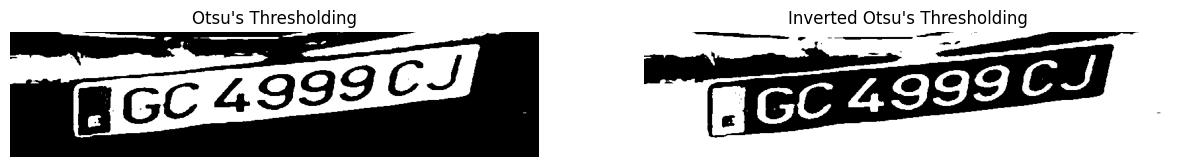

In [475]:
# Apply Thresholding and Binarization

# Apply Otsu's thresholding
thresh = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh_inv = cv2.bitwise_not(thresh)

# Display the thresholded images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Otsu's Thresholding")
plt.imshow(thresh, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Inverted Otsu's Thresholding")
plt.imshow(thresh_inv, cmap="gray")
plt.axis("off")

plt.show()

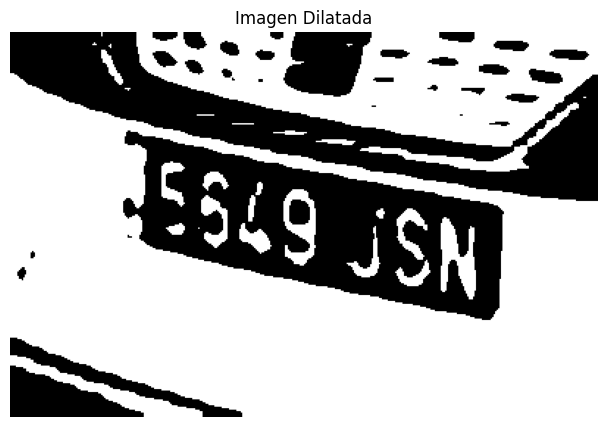

In [329]:
# Crear un kernel para la dilatación
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))

# Aplicar dilatación para resaltar los caracteres
dilated_image = cv2.dilate(thresh_inv, kernel, iterations=1)

# Mostrar la imagen dilatada
plt.figure(figsize=(10, 5))
plt.title("Imagen Dilatada")
plt.imshow(dilated_image, cmap="gray")
plt.axis("off")
plt.show()

# Detect Contours in the Image
Use contour detection algorithms to find potential character boundaries in the binarized image.

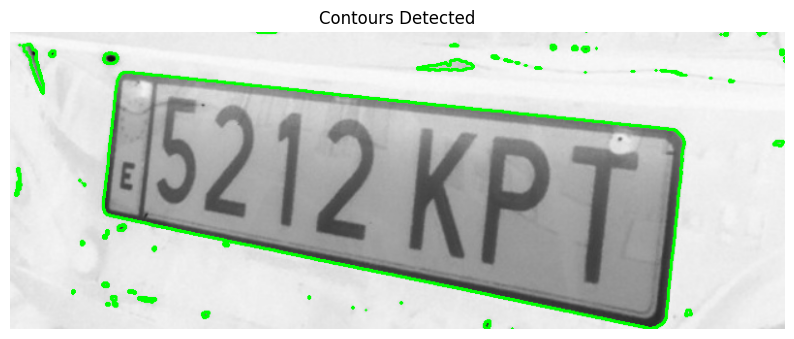

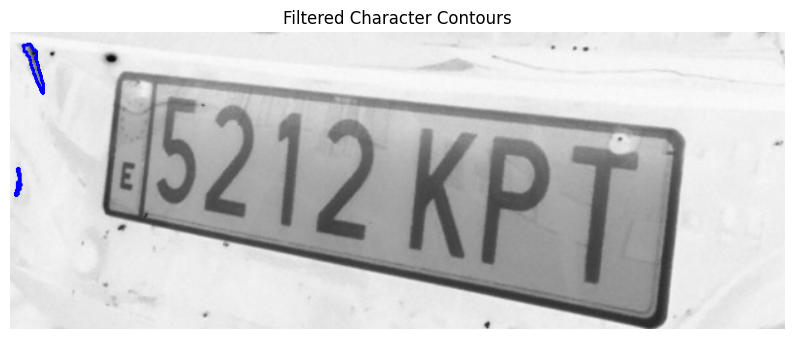

In [520]:
# Detect contours in the binarized image using Otsu's thresholding result
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original resized image to draw contours
contour_image = resized_image.copy()

# Draw the detected contours on the image
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Green color for contours

# Display the image with contours
plt.figure(figsize=(10, 5))
plt.title("Contours Detected")
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis("off")
plt.show()

# Filter contours based on size to identify potential character regions
character_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)
    if 0.2 < aspect_ratio < 1.0 and 15 < h < 100:  # Adjust thresholds as needed
        character_contours.append(contour)

# Draw filtered contours on the image
filtered_contour_image = resized_image.copy()
cv2.drawContours(filtered_contour_image, character_contours, -1, (255, 0, 0), 2)  # Blue color for filtered contours

# Display the filtered contours
plt.figure(figsize=(10, 5))
plt.title("Filtered Character Contours")
plt.imshow(cv2.cvtColor(filtered_contour_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis("off")
plt.show()

# Correcció de perspectiva

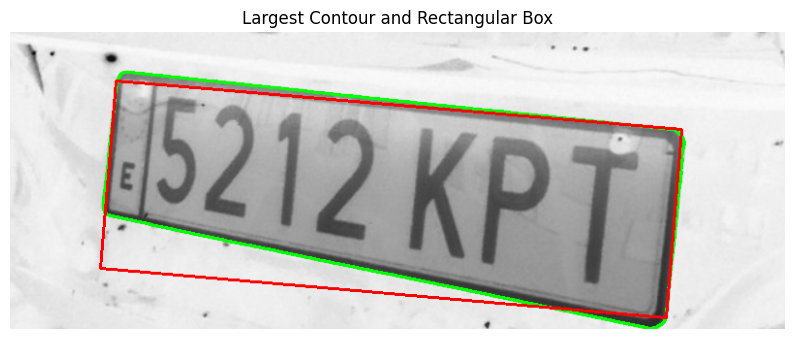

In [531]:
# Detectar contornos
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Suavizar el contorno más grande
epsilon = 0.02 * cv2.arcLength(contours[0], True)
approx = cv2.approxPolyDP(contours[0], epsilon, True)

# Calcular el rectángulo mínimo
rect = cv2.minAreaRect(approx)
box = cv2.boxPoints(rect)
box = np.int32(box)

# Ordenar los puntos del rectángulo
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left

    return rect

ordered_box = order_points(box)

# Dibujar el contorno y el rectángulo
largest_contour_img = resized_image.copy()
cv2.drawContours(largest_contour_img, [contours[0]], -1, (0, 255, 0), 2)
cv2.drawContours(largest_contour_img, [ordered_box.astype(int)], 0, (0, 0, 255), 2)

# Mostrar la imagen
plt.figure(figsize=(10, 5))
plt.title("Largest Contour and Rectangular Box")
plt.imshow(cv2.cvtColor(largest_contour_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

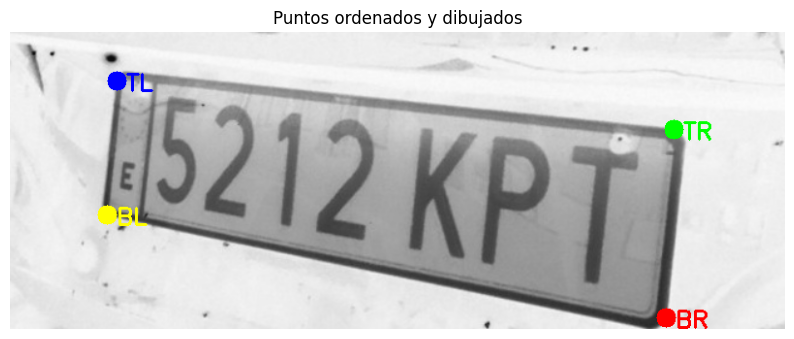

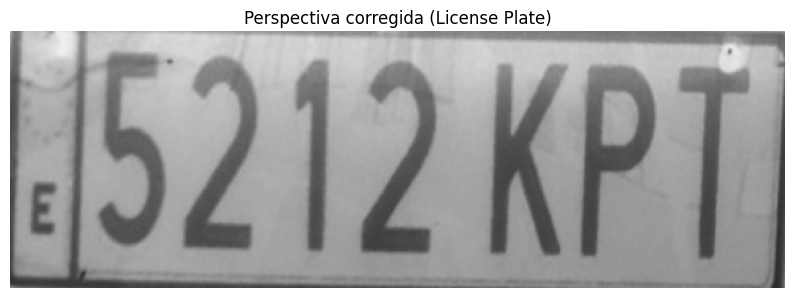

In [535]:
# Function to order points in [top-left, top-right, bottom-right, bottom-left]
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]      # top-left
    rect[2] = pts[np.argmax(s)]      # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]   # top-right
    rect[3] = pts[np.argmax(diff)]   # bottom-left

    return rect

# 1. Obtener rectángulo mínimo
rect = cv2.minAreaRect(contours[0])
box = cv2.boxPoints(rect)
box = np.array(box, dtype="float32")

# 2. Ordenar los puntos correctamente
epsilon = 0.03 * cv2.arcLength(contours[0], True)
approx = cv2.approxPolyDP(contours[0], epsilon, True)

if len(approx) == 4:
    ordered_box = order_points(approx.reshape(4, 2).astype("float32"))
    # luego haces el warp como antes
else:
    print("No se pudo encontrar un rectángulo de 4 puntos exactos.")


# 3. Visualizar para depurar
debug_img = resized_image.copy()
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)]  # TL, TR, BR, BL
labels = ['TL', 'TR', 'BR', 'BL']

for i, point in enumerate(ordered_box.astype(int)):
    cv2.circle(debug_img, tuple(point), 10, colors[i], -1)
    cv2.putText(debug_img, labels[i], tuple(point + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, colors[i], 2)

plt.figure(figsize=(10, 5))
plt.title("Puntos ordenados y dibujados")
plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# 4. Calcular tamaño del warp
width = int(max(
    np.linalg.norm(ordered_box[0] - ordered_box[1]),
    np.linalg.norm(ordered_box[2] - ordered_box[3])
))
height = int(max(
    np.linalg.norm(ordered_box[0] - ordered_box[3]),
    np.linalg.norm(ordered_box[1] - ordered_box[2])
))

# 5. Coordenadas de destino del warp
dst = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype="float32")

# 6. Warpeo
M = cv2.getPerspectiveTransform(ordered_box, dst)
warped = cv2.warpPerspective(resized_image, M, (width, height))

plt.figure(figsize=(10, 5))
plt.title("Perspectiva corregida (License Plate)")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Binarització

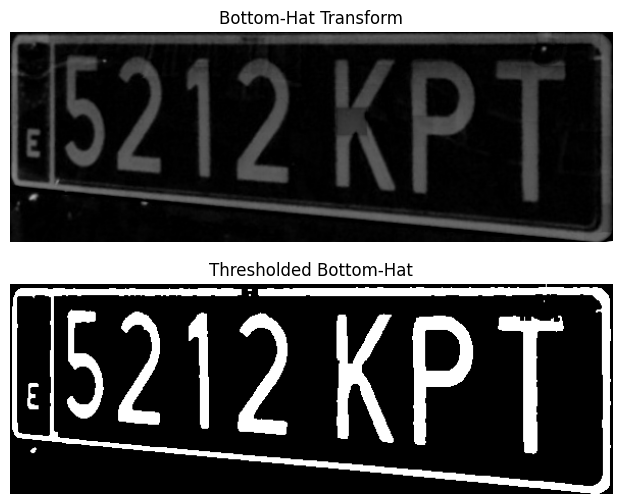

In [498]:
# Convert the warped image to grayscale for further processing
warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

# Apply CLAHE to enhance the contrast of the grayscale image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#warped_gray = clahe.apply(warped_gray)

# Apply Bottom-Hat morphological operation to extract dark text on light background

# Create a kernel for the Bottom-Hat operation
# Using a slightly larger kernel to capture character features
bottomhat_kernel = np.ones((26, 20), np.uint8)

# Apply Bottom-Hat transformation (closing - original image)
# This helps extract dark text from light background
bottomhat = cv2.morphologyEx(warped_gray, cv2.MORPH_BLACKHAT, bottomhat_kernel)

# Apply contrast enhancement to the Bottom-Hat result
clahe_bottomhat = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2, 2))
bottomhat_enhanced = clahe_bottomhat.apply(bottomhat)

# Apply thresholding to the enhanced image to binarize it
_, bottomhat_thresh = cv2.threshold(bottomhat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#bottomhat_thresh = cv2.threshold(warped_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Apply erosion to the warped threshold image
erosion_kernel = np.ones((3, 3), np.uint8)
bottomhat_thresh = cv2.erode(bottomhat_thresh, erosion_kernel, iterations=1)

# Apply additional preprocessing to clean the image
# Use opening morphology to remove small noise
opening_kernel = np.ones((2, 1), np.uint8)
bottomhat_thresh = cv2.morphologyEx(bottomhat_thresh, cv2.MORPH_OPEN, opening_kernel)

# Display the results
plt.figure(figsize=(16, 6))

plt.subplot(2, 1, 1)
plt.title("Bottom-Hat Transform")
plt.imshow(bottomhat, cmap="gray")
plt.axis("off")

plt.subplot(2, 1, 2)
plt.title("Thresholded Bottom-Hat")
plt.imshow(bottomhat_thresh, cmap="gray")
plt.axis("off")

plt.show()

# Detecció i eliminació de ruido

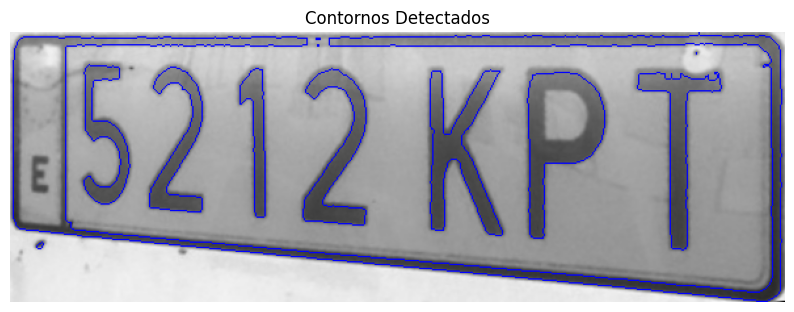

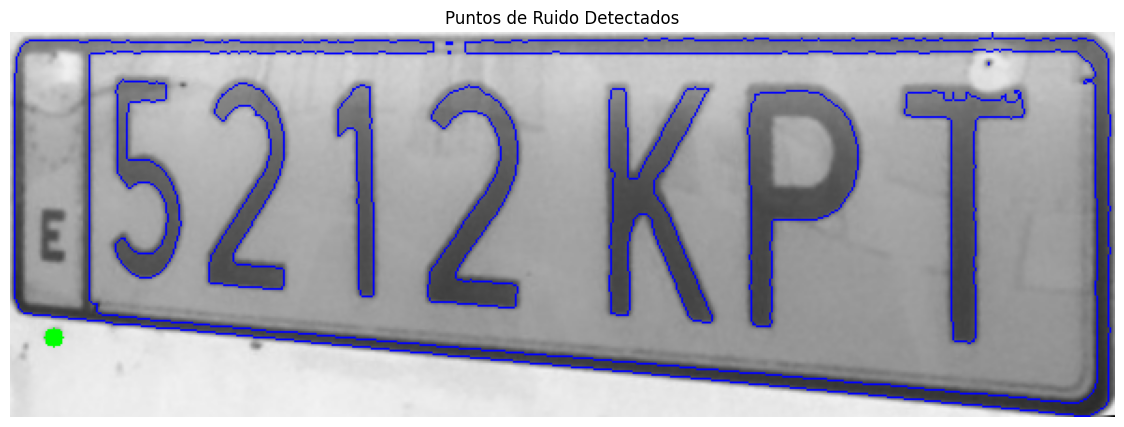

In [499]:
# Detectar contornos en la imagen binarizada
contours, _ = cv2.findContours(bottomhat_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una copia de la imagen para visualizar los puntos de ruido
noise_points_image = warped.copy()

# Dibujar todos los contornos detectados en la imagen
cv2.drawContours(noise_points_image, contours, -1, (255, 0, 0), 1)  # Color azul para los contornos

# Mostrar la imagen con los contornos detectados
plt.figure(figsize=(10, 5))
plt.title("Contornos Detectados")
plt.imshow(cv2.cvtColor(noise_points_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Filtrar contornos pequeños que representan ruido
for contour in contours:
    area = cv2.contourArea(contour)
    if 10 <= area <= 30:  # Ajustar el umbral para puntos medianos
        # Dibujar un círculo alrededor del punto mediano
        x, y, w, h = cv2.boundingRect(contour)
        cv2.circle(noise_points_image, (x + w // 2, y + h // 2), radius=5, color=(0, 255, 0), thickness=-1)

# Mostrar la imagen con los puntos de ruido detectados
plt.figure(figsize=(16, 5))
plt.title("Puntos de Ruido Detectados")
plt.imshow(cv2.cvtColor(noise_points_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

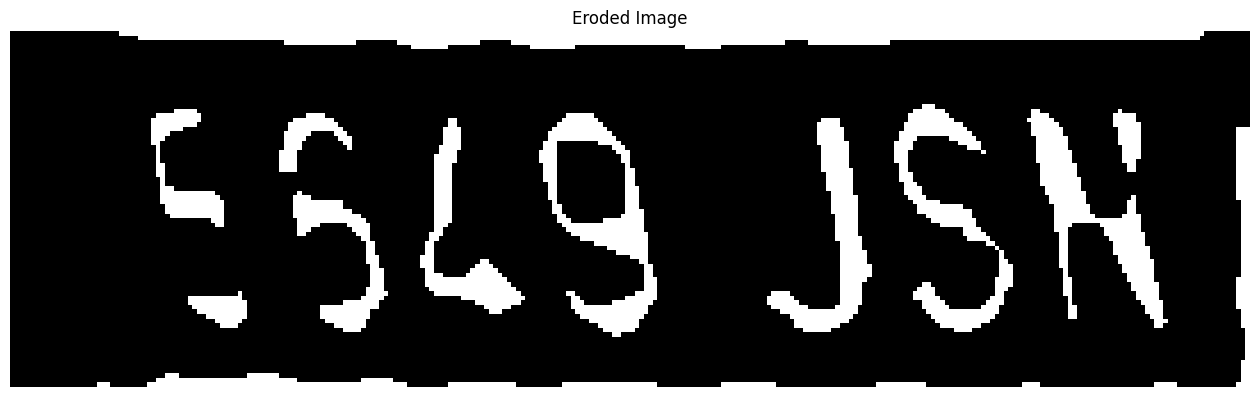

In [335]:
# Apply erosion to remove small noise points from the thresholded image

# Create a slightly larger kernel for erosion
erosion_kernel = np.ones((3, 3), np.uint8)

# Apply erosion to the warped threshold image
bottomhat_thresh = cv2.erode(bottomhat_thresh, erosion_kernel, iterations=1)

# Display the eroded image
plt.figure(figsize=(16, 5))
plt.title("Eroded Image")
plt.imshow(bottomhat_thresh, cmap="gray")
plt.axis("off")
plt.show()

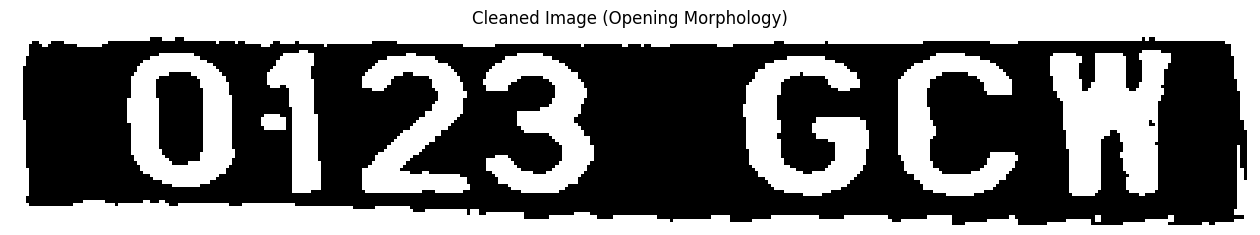

In [163]:
# Apply additional preprocessing to clean the image
# Use opening morphology to remove small noise
opening_kernel = np.ones((2, 1), np.uint8)
bottomhat_thresh = cv2.morphologyEx(bottomhat_thresh, cv2.MORPH_OPEN, opening_kernel)

# Display the cleaned image
plt.figure(figsize=(16, 5))
plt.title("Cleaned Image (Opening Morphology)")
plt.imshow(bottomhat_thresh, cmap="gray")
plt.axis("off")
plt.show()

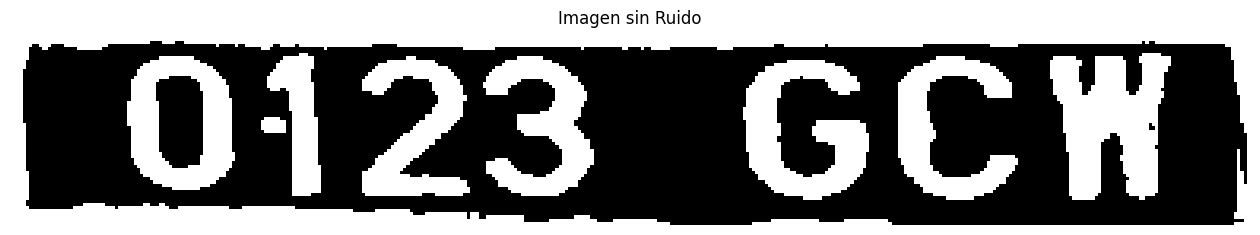

In [146]:
# Detectar y eliminar el punto de ruido

# Detectar contornos en la imagen dilatada
contours, _ = cv2.findContours(bottomhat_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una máscara vacía del mismo tamaño que la imagen
mask = np.zeros_like(bottomhat_thresh)

# Filtrar contornos basados en el área
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 10:  # Ajusta este umbral según el tamaño del ruido
        # Dibujar los contornos aceptados en la máscara
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

# Aplicar la máscara para eliminar el ruido
bottomhat_thresh = cv2.bitwise_and(bottomhat_thresh, mask)

# Mostrar el resultado
plt.figure(figsize=(16, 5))
plt.title("Imagen sin Ruido")
plt.imshow(bottomhat_thresh, cmap="gray")
plt.axis("off")
plt.show()

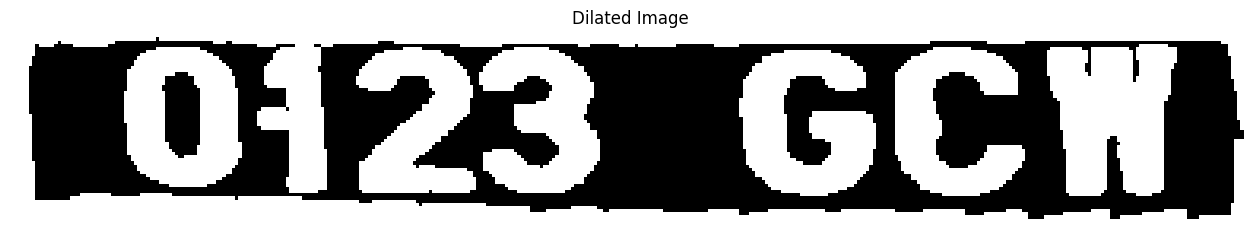

In [126]:
# Apply dilation to reconnect potentially broken character parts
dilation_kernel = np.ones((3, 4), np.uint8)
bottomhat_thresh = cv2.dilate(bottomhat_thresh, dilation_kernel, iterations=1)

# Display the dilated image
plt.figure(figsize=(16, 5))
plt.title("Dilated Image")
plt.imshow(bottomhat_thresh, cmap="gray")
plt.axis("off")
plt.show()

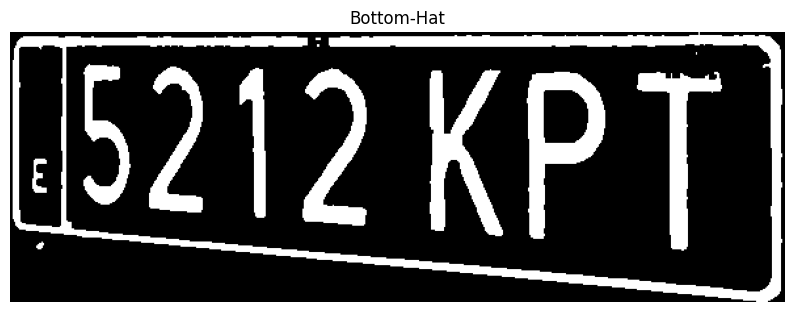

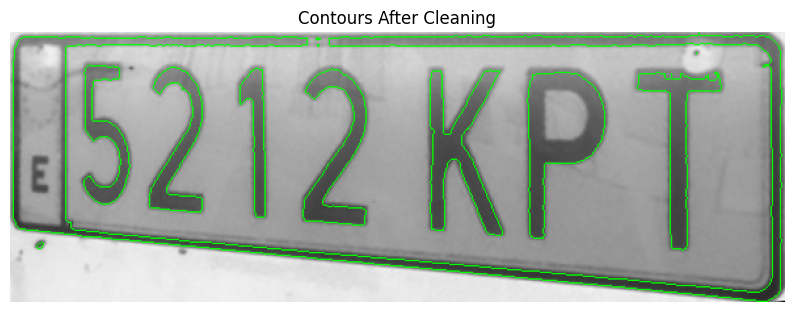

In [500]:
# Find contours in the cleaned image
contours_cleaned, _ = cv2.findContours(bottomhat_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours on a copy of the warped image
contour_image = warped.copy()
cv2.drawContours(contour_image, contours_cleaned, -1, (0, 255, 0), 1)

plt.figure(figsize=(10, 5))
plt.title("Bottom-Hat")
plt.imshow(bottomhat_thresh, cmap="gray")
plt.axis("off")

plt.figure(figsize=(10, 5))
plt.title("Contours After Cleaning")
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

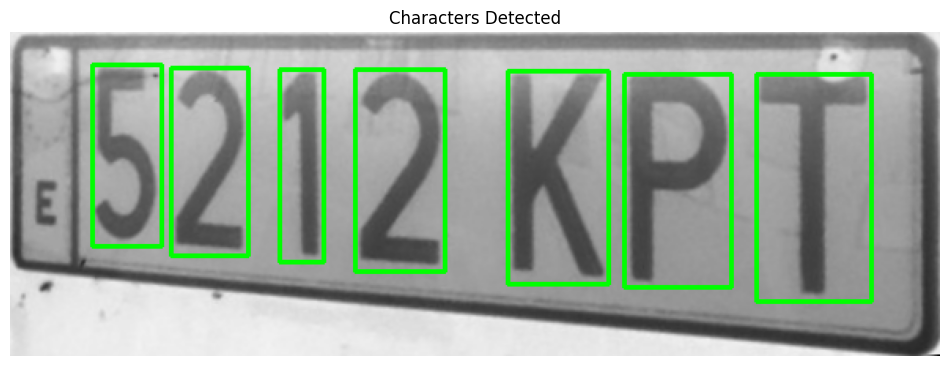

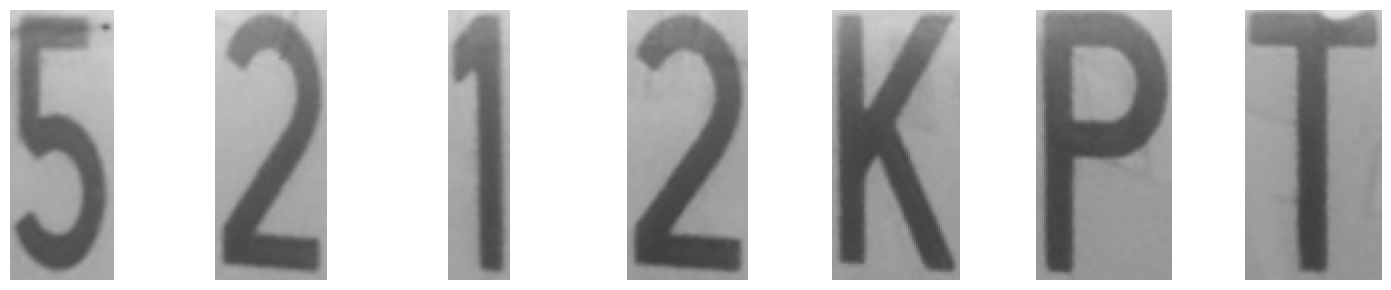

In [501]:
# Segment characters from the license plate

# Sort contours from left to right to get characters in reading order
contours_cleaned_list = list(contours_cleaned)
sorted_contours = sorted(contours_cleaned_list, key=lambda c: cv2.boundingRect(c)[0])

# Create a copy of the warped image to draw bounding boxes on
matricula_img = warped.copy()

# List to store individual character images
character_images = []

# Define margin size
margin = 4  # Adjust as needed

# Process each contour
for i, contour in enumerate(sorted_contours):
    # Get the bounding rectangle for the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Add margin to the bounding box
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(warped.shape[1] - x, w + 2 * margin)
    h = min(warped.shape[0] - y, h + 2 * margin)
    
    # Filter contours based on aspect ratio and size (characters in license plates)
    aspect_ratio = w / float(h)
    area = cv2.contourArea(contour)
    
    # Adjust these thresholds based on your specific license plate
    if 0.2 < aspect_ratio < 1.5 and area > 120 and h > 10:
        # Draw a rectangle around the character
        cv2.rectangle(matricula_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Extract the character from the binary image
        char_roi = warped[y:y+h, x:x+w]
        
        # Add to our list of character images
        character_images.append((x, char_roi))

# Sort characters by x-coordinate to get them in the correct order
character_images.sort(key=lambda x: x[0])

# Display the characters with bounding boxes
plt.figure(figsize=(12, 5))
plt.title("Characters Detected")
plt.imshow(cv2.cvtColor(matricula_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Display each extracted character
plt.figure(figsize=(15, 3))
for i, (_, char_img) in enumerate(character_images):
    if i < 15:  # Limit to avoid too many subplots
        plt.subplot(1, min(len(character_images), 15), i+1)
        plt.imshow(cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
plt.tight_layout()
plt.show()

In [59]:
from tensorflow.keras.models import load_model
model = load_model('../caracter_model.keras')

In [60]:
# Function to preprocess character images for prediction
def preprocess_character(char_img):
    # Resize to the expected input size of the model
    char_img = cv2.resize(char_img, (32, 32))
    # Convert to grayscale
    char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
    # Normalize pixel values to [0, 1]
    char_img = char_img.astype('float32') / 255.0
    # Reshape for model input
    char_img = np.expand_dims(char_img, axis=-1)  # Add channel dimension
    char_img = np.expand_dims(char_img, axis=0)  # Add batch dimension
    return char_img

In [61]:
# Function to predict characters using the loaded model
def predict_character(model, char_img):
    # Preprocess the character image
    processed_char = preprocess_character(char_img)
    # Predict the character
    prediction = model.predict(processed_char)
    # Get the index of the class with the highest probability
    predicted_class = np.argmax(prediction, axis=1)[0]
    # Get the confidence level (probability of the predicted class)
    confidence = prediction[0][predicted_class]
    return predicted_class, confidence

In [62]:
# Convert predicted classes to corresponding characters {'0': 0, ..., 'A': 10, ..., 'Z': 35}
def class_to_char(class_index):
    if 0 <= class_index <= 9:
        return str(class_index)  # Digits 0-9
    elif 10 <= class_index <= 35:
        return chr(class_index - 10 + ord('A'))  # Letters A-Z
    else:
        return '?'  # Unknown character

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


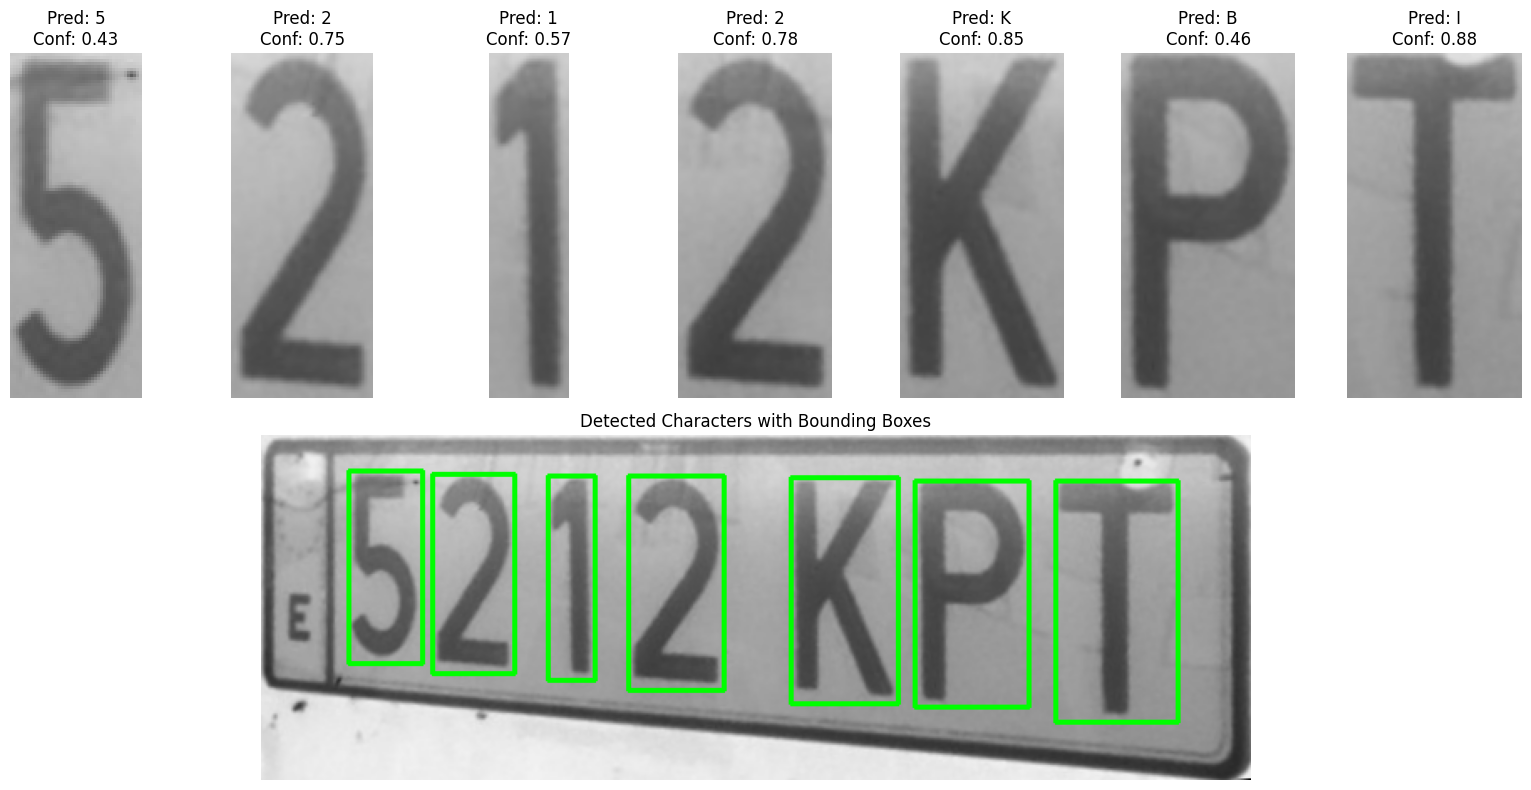

In [502]:
# Predict characters using the model
predicted_characters = []
confidence_levels = []  # List to store confidence levels
for _, char_img in character_images:
    predicted_class, confidence = predict_character(model, char_img)
    predicted_characters.append(predicted_class)
    confidence_levels.append(confidence)

# Convert predicted classes to characters
predicted_chars = [class_to_char(c) for c in predicted_characters]

# Visualizar los caracteres predichos y sus niveles de confianza en subplots
plt.figure(figsize=(16, 8))

# Mostrar cada carácter predicho con su nivel de confianza
for i, (_, char_img) in enumerate(character_images):
    plt.subplot(2, len(character_images), i + 1)
    plt.imshow(cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Pred: {predicted_chars[i]}\nConf: {confidence_levels[i]:.2f}")
    plt.axis("off")

# Mostrar la imagen completa con los caracteres detectados
plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(matricula_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Characters with Bounding Boxes")
plt.axis("off")

plt.tight_layout()
plt.show()